# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [2]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

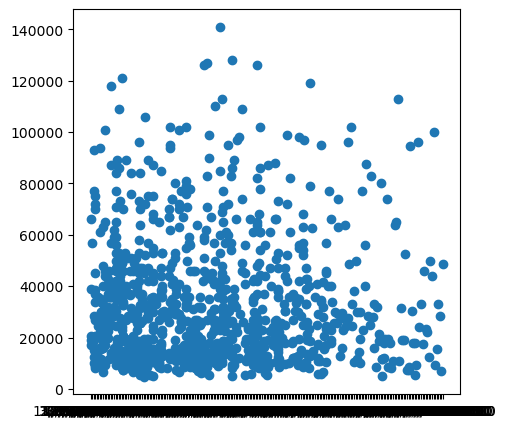

In [5]:
fig, ax =  plt.subplots(figsize=(5, 5))
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [7]:
df["saledate"][:1000], df["SalePrice"][:1000]

(0      11/16/2006 0:00
 1       3/26/2004 0:00
 2       2/26/2004 0:00
 3       5/19/2011 0:00
 4       7/23/2009 0:00
             ...       
 995     7/16/2009 0:00
 996     6/14/2007 0:00
 997     9/22/2005 0:00
 998     7/28/2005 0:00
 999     6/16/2011 0:00
 Name: saledate, Length: 1000, dtype: object,
 0      66000.0
 1      57000.0
 2      10000.0
 3      38500.0
 4      11000.0
         ...   
 995    33000.0
 996    62000.0
 997     8000.0
 998    16000.0
 999    14500.0
 Name: SalePrice, Length: 1000, dtype: float64)

In [8]:
df["saledate"].dtype

dtype('O')

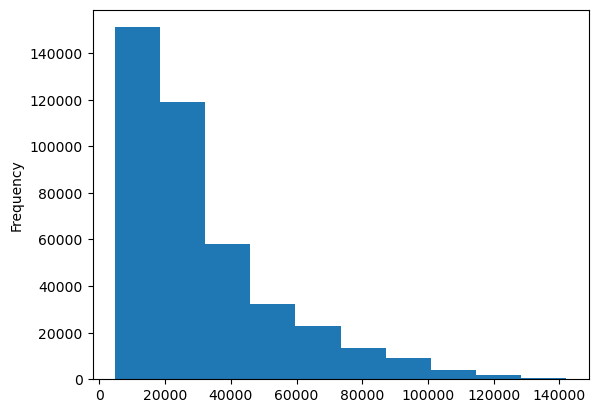

In [10]:
df["SalePrice"].plot(kind="hist");

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [11]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [12]:
df["saledate"].dtype

dtype('<M8[ns]')

In [13]:
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

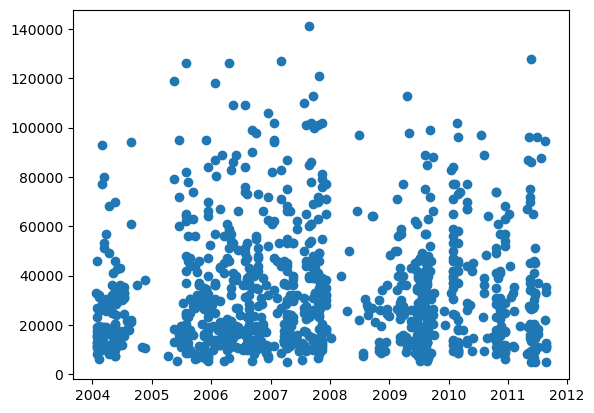

In [14]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [15]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [17]:
df["saledate"][:20]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [18]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [19]:
df["saledate"].tail()

410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [20]:
df_tmp = df.copy()

In [21]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Add datetime parameters for `saledate` column

In [22]:
df["saledate"][:1]

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [23]:
df_tmp["saledate"][:1].dt.year

205615    1989
Name: saledate, dtype: int64

In [24]:
df_tmp["saledate"][:1].dt.day

205615    17
Name: saledate, dtype: int64

In [25]:
df_tmp["saledate"][:1].dt.month

205615    1
Name: saledate, dtype: int64

In [26]:
df_tmp["saleYear"] = df_tmp["saledate"].dt.year
df_tmp["saleMonth"] = df_tmp["saledate"].dt.month
df_tmp["saleDay"] = df_tmp["saledate"].dt.day
df_tmp["saleDayofweek"] = df_tmp["saledate"].dt.dayofweek
df_tmp["saleDayofYear"] = df_tmp["saledate"].dt.dayofyear

In [27]:
df_tmp.head().T.tail()

,205615,274835,141296,212552,62755
saleYear,1989,1989,1989,1989,1989
saleMonth,1,1,1,1,1
saleDay,17,31,31,31,31
saleDayofweek,1,1,1,1,1
saleDayofYear,17,31,31,31,31


Now we've enriched our DataFrame with date time features, we can remove 'saledate'

In [28]:
df_tmp.drop("saledate", axis=1, inplace=True)

In [29]:
df_tmp["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [30]:
len(df_tmp)

412698

## 5. Modelling 

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [31]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=42)
from sklearn.model_selection import train_test_split

x = df_tmp.drop("SalePrice", axis=1)
y = df_tmp["SalePrice"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model.fit(x_train, y_train)
model.score(x_test, y_test)

ValueError: could not convert string to float: 'Medium'

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 1

In [33]:
df_tmp["UsageBand"].dtype

dtype('O')

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html

In [35]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [36]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [45]:
for label, content in df_tmp.items():
    print(label)
    print(content)

SalesID
205615    1646770
274835    1821514
141296    1505138
212552    1671174
62755     1329056
           ...   
410879    6302984
412476    6324811
411927    6313029
407124    6266251
409203    6283635
Name: SalesID, Length: 412698, dtype: int64
SalePrice
205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
410879    16000.0
412476     6000.0
411927    16000.0
407124    55000.0
409203    34000.0
Name: SalePrice, Length: 412698, dtype: float64
MachineID
205615    1126363
274835    1194089
141296    1473654
212552    1327630
62755     1336053
           ...   
410879    1915521
412476    1919104
411927    1918416
407124     509560
409203    1869284
Name: MachineID, Length: 412698, dtype: int64
ModelID
205615     8434
274835    10150
141296     4139
212552     8591
62755      4089
          ...  
410879     5266
412476    19330
411927    17244
407124     3357
409203     4701
Name: ModelID, Length: 412698, dtype: int64
datasource
2

In [51]:
for label, content in df_tmp.items():
#     if pd.api.types.is_string_dtype(df_tmp[label]):
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [55]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [56]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [60]:
df_tmp["state"].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [61]:
df_tmp["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [70]:
round(df_tmp.isna().sum()/len(df_tmp) * 100)

SalesID                      0.0
SalePrice                    0.0
MachineID                    0.0
ModelID                      0.0
datasource                   0.0
auctioneerID                 5.0
YearMade                     0.0
MachineHoursCurrentMeter    64.0
UsageBand                   82.0
fiModelDesc                  0.0
fiBaseModel                  0.0
fiSecondaryDesc             34.0
fiModelSeries               86.0
fiModelDescriptor           82.0
ProductSize                 52.0
fiProductClassDesc           0.0
state                        0.0
ProductGroup                 0.0
ProductGroupDesc             0.0
Drive_System                74.0
Enclosure                    0.0
Forks                       52.0
Pad_Type                    80.0
Ride_Control                63.0
Stick                       80.0
Transmission                54.0
Turbocharged                80.0
Blade_Extension             94.0
Blade_Width                 94.0
Enclosure_Type              94.0
Engine_Hor

### Save preprocessed data

In [6]:
df_tmp.to_csv("data/train_tmp.csv", index=False)

NameError: name 'df_tmp' is not defined

In [7]:
df_tmp = pd.read_csv("data/train_tmp.csv", low_memory=False)
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,44,44,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,9,9,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,9,9,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,9,9,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,9,9,...,True,True,True,True,True,False,False,False,True,True


In [8]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Fill missing values 
#### Fill numerical missing values first

In [9]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofYear
auctioneerID_is_missing
MachineHoursCurrentMeter_is_missing
UsageBand_is_missing
fiModelDesc_is_missing
fiBaseModel_is_missing
fiSecondaryDesc_is_missing
fiModelSeries_is_missing
fiModelDescriptor_is_missing
ProductSize_is_missing
fiProductClassDesc_is_missing
state_is_missing
Pro

In [10]:
df_tmp["ModelID"].head(3)

0     8434
1    10150
2     4139
Name: ModelID, dtype: int64

In [11]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum() > 0:
            print(label)

In [12]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [13]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum() > 0:
            print(label)
# No answer means no null value columns

In [14]:
df_tmp["auctioneerID_is_missing"].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [15]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Filling and turning categorical variables into numbers

In [16]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [17]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [18]:
pd.Categorical(df_tmp["UsageBand"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [19]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # add 1 with string value for making -1 to 0 & 
            df_tmp[label] = pd.Categorical(content).codes + 1

In [20]:
df_tmp["UsageBand"]

0         44
1          9
2          9
3          9
4          9
          ..
412693     5
412694     5
412695     5
412696     5
412697     5
Name: UsageBand, Length: 412698, dtype: int64

In [21]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int64(54)
memory usage: 197.6 MB


In [22]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [23]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [24]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,44,44,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,9,9,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,9,9,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,9,9,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,9,9,...,True,True,True,True,True,False,False,False,True,True


In [29]:
# %%time
# from sklearn.ensemble import RandomForestRegressor
# x = df_tmp.drop(["SalePrice"], axis=1)
# y = df_tmp["SalePrice"]

# model = RandomForestRegressor(n_jobs=-1, random_state=42)

# model.fit(x, y)

# CPU times: total: 47min 48s
# Wall time: 4min 17s

CPU times: total: 47min 48s
Wall time: 4min 17s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [30]:
model.score(x, y)

0.9852257620765279

**Question:** Why doesn't the above metric hold water? (why isn't the metric reliable)

### Splitting data into train/validation sets

In [31]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [32]:
# Split data into training and validation
df_val = df_tmp[df_tmp["saleYear"] == 2012]
df_train = df_tmp[df_tmp["saleYear"] != 2012]

len(df_train), len(df_val)

(401125, 11573)

In [69]:
np.random.seed(42)
x = df_tmp.drop(["SalePrice"], axis=1)
y = df_tmp["SalePrice"]

x_train, y_train = df_train.drop(["SalePrice"], axis=1), df_train["SalePrice"]
x_valid, y_valid = df_val.drop(["SalePrice"], axis=1), df_val["SalePrice"]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [34]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

In [51]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.metrics import r2_score
def rmsle(y_test, y_preds): 
    """
    Caculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_score(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds), 
              "Valid MAE": mean_absolute_error(y_valid, val_preds), 
              "Training RMSLE": rmsle(y_train, train_preds), 
              "Valid RMSLE": rmsle(y_valid, val_preds), 
              "Training R^2": r2_score(y_train, train_preds), 
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [36]:
# %%time
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model.fit(x_train, y_train)

In [40]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [41]:
len(x_train)

401125

In [44]:
x_train.shape[0]

401125

In [45]:
# If we use n_estimators = 100, 40112500 possible combination must be run to fit the model. max_samples on try specified limit.
x_train.shape[0] * 100

40112500

In [47]:
10000 * 100

1000000

In [48]:
40112500 / 1000000

40.1125

In [53]:
%%time
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(x_train, y_train)

CPU times: total: 1min 27s
Wall time: 8.51 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [54]:
show_score(model)

{'Training MAE': 6407.885300392647,
 'Valid MAE': 8633.326159163571,
 'Training RMSLE': 0.3039361354447437,
 'Valid RMSLE': 0.3789932056768934,
 'Training R^2': 0.8179641412786905,
 'Valid R^2': 0.7681849235754674}

### Hyperparameter tuning with RandomizedSearchCV

In [65]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {"n_estimators": np.arange(10, 100, 10), 
           "max_depth": [None, 3, 5, 10], 
           "min_samples_split": np.arange(2, 20, 2), 
           "min_samples_leaf": np.arange(1, 20, 2), 
           "max_features": [0.5, 1, "sqrt", "auto"], 
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), rf_grid, n_iter=2, cv=5, verbose=2)
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=10, n_estimators=50; total time=   8.6s
[CV] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=10, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=10, n_estimators=50; total time=   1.8s
[CV] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=10, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=10, n_estimators=50; total time=   2.0s
[CV] END max_depth=10, max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=14, n_estimators=80; total time=   1.8s
[CV] END max_depth=10, max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_sp

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=2)

In [66]:
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 11,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

In [67]:
show_score(rs_model)

{'Training MAE': 10091.5676015869,
 'Valid MAE': 12609.397341040287,
 'Training RMSLE': 0.44080530908102683,
 'Valid RMSLE': 0.4926214613243711,
 'Training R^2': 0.5957059765879077,
 'Valid R^2': 0.5450068554824807}

### Train a model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [71]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) 
# random state so our results are reproducible
# Fit the ideal model
ideal_model.fit(x_train, y_train)

CPU times: total: 8min 44s
Wall time: 52.7 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [76]:
# Scores for ideal_model (trained on all the data)
show_score(ideal_model)

{'Training MAE': 3336.2286607311794,
 'Valid MAE': 7126.92020596274,
 'Training RMSLE': 0.1663572965638944,
 'Valid RMSLE': 0.3153219025690698,
 'Training R^2': 0.9475772732711544,
 'Valid R^2': 0.8337151764521071}

In [77]:
# Scores on rs_model (only trained on ~10,000 examples)
show_score(rs_model)

{'Training MAE': 10091.5676015869,
 'Valid MAE': 12609.397341040287,
 'Training RMSLE': 0.44080530908102683,
 'Valid RMSLE': 0.4926214613243711,
 'Training R^2': 0.5957059765879077,
 'Valid R^2': 0.5450068554824808}

## Make predictions on test data

In [93]:
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [94]:
# Make Prediction on the test dataset.
test_preds = ideal_model.predict(df_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

In [95]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [96]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [97]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [98]:
x_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [99]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [100]:
df_test = preprocess_data(df_test)

In [103]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True


In [104]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 101, dtype: int64

In [110]:
# Make Prediction on the updated test dataset.
test_preds = ideal_model.predict(df_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saleDayOfWeek
- saleDayOfYear
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing
- saleDayofYear
- saleDayofweek

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

In [111]:
x_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,44,44,44,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,9,9,9,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,9,9,9,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,9,9,9,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,9,9,9,...,True,True,True,True,True,False,False,False,True,True


In [115]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [114]:
set(x_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing', 'saleDayofYear', 'saleDayofweek'}

In [120]:
df_test["saleDayOfYear"].isna().sum()

0

In [121]:
df_test["saleDayOfWeek"].isna().sum()

0

In [123]:
x_train["saleDayofYear"].isna().sum()

0

In [124]:
x_train["saleDayofweek"].isna().sum()

0

In [126]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [127]:
set(x_train.columns) - set(df_test.columns)

{'saleDayofYear', 'saleDayofweek'}

Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [129]:
test_preds = ideal_model.predict(df_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saleDayOfWeek
- saleDayOfYear
Feature names seen at fit time, yet now missing:
- saleDayofYear
- saleDayofweek

  warnings.warn(message, FutureWarning)


In [130]:
len(test_preds)

12457

In [131]:
test_preds

array([41883.08769662, 30628.4355499 , 66022.27691224, ...,
       43313.11801513, 55927.76177004, 64984.92165986])

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [132]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,41883.087697
1,1227844,30628.435550
2,1227847,66022.276912
3,1227848,64968.221045
4,1227863,31764.668431
...,...,...
12452,6643171,62795.695465
12453,6643173,50696.252857
12454,6643184,43313.118015
12455,6643186,55927.761770


In [133]:
df_preds.to_csv("data/test_prediction.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [138]:
ideal_model.feature_importances_

array([6.03951360e-02, 3.67370081e-02, 1.90207489e-01, 3.10497719e-03,
       4.84862581e-03, 2.23225202e-01, 6.96382868e-03, 4.81994778e-04,
       3.51309471e-04, 3.44465060e-04, 3.94948407e-04, 3.33660835e-04,
       3.61069273e-04, 4.22233926e-04, 3.62465875e-04, 3.43160499e-04,
       3.32100954e-04, 3.35781071e-04, 3.43275146e-04, 3.48155689e-04,
       3.76191739e-04, 3.68661184e-04, 3.55543745e-04, 3.62173420e-04,
       3.55467465e-04, 4.31911916e-04, 3.51710528e-04, 3.43255788e-04,
       3.42216674e-04, 3.66027488e-04, 4.00804964e-04, 4.17783185e-04,
       3.42419922e-04, 3.54651320e-04, 3.87026660e-04, 3.54157327e-04,
       3.66397074e-04, 3.58094876e-04, 4.63640362e-04, 3.47985974e-04,
       4.15560334e-04, 3.54110914e-04, 4.51916907e-04, 3.84753879e-04,
       3.67717004e-04, 3.36480199e-04, 3.99245881e-04, 3.31437652e-04,
       4.21857330e-04, 3.40265881e-04, 3.44069198e-04, 7.40735373e-02,
       4.46776773e-03, 7.70354095e-03, 3.96377409e-03, 1.23902567e-02,
      

In [165]:
def plot_features(columns, importance, n=20):
    df = (pd.DataFrame({"features": columns, 
                        "feature_importance": importance})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importance"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("feature importances")
    ax.invert_yaxis()

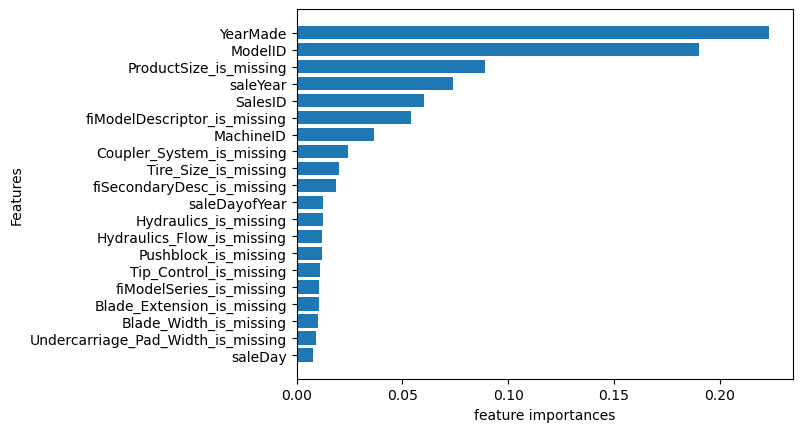

In [166]:
plot_features(x_train.columns, ideal_model.feature_importances_)

In [167]:
x_train["ProductSize"].value_counts()

9     63944
44    51682
5     29019
49    15955
10    14309
20    12965
24    12961
35    12190
6     11254
13    11209
30    10882
33    10404
43    10027
1      9997
38     9941
41     9794
3      9173
32     8604
7      8128
23     7734
25     6961
28     6693
18     6450
17     5278
19     5095
14     4086
4      3869
31     3529
46     2895
45     2801
29     2724
52     2668
48     2288
12     2018
37     1775
22     1763
53     1662
26     1327
36     1311
15     1215
51      746
27      722
16      659
8       509
2       430
34      410
21      328
47      300
42      203
11      118
40       82
39       36
50        2
Name: ProductSize, dtype: int64

In [168]:
df["ProductSize"].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [169]:
df["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? 
**Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.